In [1]:
import os
import sys
import copy
import json
from collections import defaultdict

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import patheffects
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon, Rectangle, FancyBboxPatch
from matplotlib.collections import PatchCollection

from seelab.visualize import get_labelme_annotations, rgb_to_rgba

In [2]:
colors_map = {
    'gang form': rgb_to_rgba((30, 144, 255), 0.5),
    'person': rgb_to_rgba((0, 128, 0), 0.5),
    'support': rgb_to_rgba((138, 43, 226), 0.5),
    'hardhat': rgb_to_rgba((255, 255, 0), 0.5),
    'pallet': rgb_to_rgba((255, 95, 119), 0.5),
    'concrete pump truck': rgb_to_rgba((255, 0, 0), 0.5)
}

### Figure 1. 

In [3]:
image_path = './inputs/labelme/00000957.jpg'


def draw_plot1(ax, shape):
    image = Image.open(image_path)
    image = image.crop((0, 0, 400, 397))
    ax.imshow(image)
    for shape in shapes['polygons']:
        if shape['label'] not in ['panel']: 
            points = np.asarray(shape['points'])
            color = colors_map.get(shape['label'], ((0, 0, 0, 1), (0, 0, 0, 1)))
            polygon = Polygon(np.asarray(shape['points']), True, fc=color[0], ec=color[1])
            ax.add_patch(polygon)
            
    ax.tick_params(axis='both', bottom=False, left=False, labelleft=False, labelbottom=False)
    

def draw_plot2(ax, shape):
    image = Image.open(image_path)
    image = image.crop((0, 0, 400, 397))
    w, h = image.size
    # image = image.resize((int(w*0.8), int(h*0.8)))
    ax.imshow(image, alpha=0.1)
    for shape in shapes['polygons']:
        if shape['label'] == 'person': 
            polygon = np.asarray(shape['points'])
            color = colors_map.get('person', 1)
            patches = Polygon(np.asarray(polygon), True, fc=color[0], ec=color[1])
            ax.add_patch(patches)
            
            line = Line2D(
                np.asarray(polygon)[:, 0], np.asarray(polygon)[:, 1], 
                linewidth=0.5, color='black', markersize=3., marker='o',
                markeredgecolor='none', markeredgewidth=.5)  # markeredgecolor='r'
            ax.add_line(line)
    
    for shape in shapes['boxes']:
        if shape['label'] == 'person': 
            box = np.asarray(shape['points'])

    rectangles = FancyBboxPatch((box[0], box[1]), box[2], box[3], fc=color[0], ec=color[1], boxstyle='square,pad=0.')
    ax.add_patch(rectangles)

    boxes = [
        [box[0], box[1]],
        [box[0]+box[2], box[1]],
        [box[0], box[1]+box[3]],
        [box[0]+box[2], box[1]+box[3]]
    ]

    texts = ['(min x, min y)', '(max x, min y)', '(min x, max y)', '(max x, max y)']
    va = 'bottom'
    offset = -8
    for i, (box, text) in enumerate(zip(boxes, texts)):
        ax.scatter(box[0], box[1], c='g', s=10,)  # ec='w', lw=0.5
        if i > 1:
            va = 'top'
            offset = 8
        ax.annotate(
            text, (box[0], box[1]+offset), color='black', 
            weight='bold', fontsize=5, ha='center', va=va)
        
    # ax.annotate(
        # 'Polygon to bound', (80, 60),  xytext=(70, 85), color='black', weight='bold', 
        # fontsize=7, ha='left', va='top', arrowprops={'arrowstyle': '->'})
    # ax.annotate(
        # 'Bounding box', (40, 8),  xytext=(2, 20), color='black', weight='bold', 
        # fontsize=7, ha='left', va='top', arrowprops={'arrowstyle': '->'})
    ax.axis('off')
   
    
def draw_plot3(ax, shape):
    image = Image.open(image_path)
    image = image.crop((0, 0, 400, 397))
    ax.imshow(image)
    for shape in shapes['boxes']:
        if shape['label'] in ['person', 'hardhat']:
            box = shape['points']
            color = color = colors_map.get(shape['label'], ((0, 0, 0, 1), (0, 0, 0, 1)))
            rectangle = Rectangle((box[0], box[1]), box[2], box[3], fc=color[0], ec=color[1])
            ax.add_patch(rectangle)
            
            ax.annotate(
                shape['label'], (box[0], box[1]), color='w', weight='bold', 
                fontsize=5, ha='left', va='bottom', 
                bbox=dict(facecolor=color[1], edgecolor=color[1], pad=0.0))
            
    ax.tick_params(axis='both', bottom=False, left=False, labelleft=False, labelbottom=False)

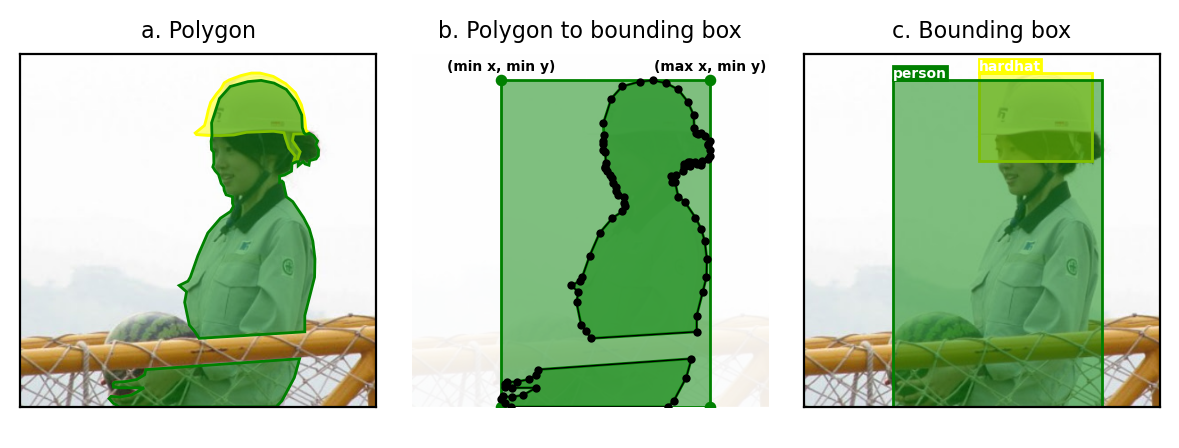

In [4]:
shapes = get_labelme_annotations('./inputs/labelme/00000957.json', xywh=True)

fig, axes = plt.subplots(1, 3, dpi=200)


draw_plot1(axes.flat[0], shapes)
axes.flat[0].set_title('a. Polygon', fontsize=8)

draw_plot2(axes.flat[1], shapes)
axes.flat[1].set_title('b. Polygon to bounding box', fontsize=8)

draw_plot3(axes.flat[2], shapes)
axes.flat[2].set_title('c. Bounding box', fontsize=8)

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.14)
plt.show()
# fig.savefig('./outputs/fig-0204.png', bbox_inches='tight')  # pad_inches

### Figure 1. Representation of our dataset 

In [5]:
images_by_categories = {
    'Structure (with temporary)': [
        '10000000.jpg', '10000351.jpg', '00002400.jpg', '10000000.jpg', 
        '10000000.jpg', '10000000.jpg', '10000000.jpg', '10000000.jpg', ],
    
    'Material and part': [
        '10000400.jpg', '10000400.jpg', '10000000.jpg', '10000000.jpg', 
        '10000000.jpg', '10000000.jpg', '10000000.jpg', '10000000.jpg', ],
    
    'Heavy equipment': [
        '00000961.jpg', '00000963.jpg', '00001527.jpg', '00002982.jpg', 
        '00002306.jpg', '00002548.jpg', '00002978.jpg', '10000000.jpg', ],
    
    'Object': [
        '00000911.jpg', '00000979.jpg', '10000250.jpg', '00000955.jpg', 
        '00001906.jpg', '00002336.jpg', '10000351.jpg', '00002339.jpg']
}

In [6]:
def concat_horizon(root='./inputs/labelme/', images=None):
    width = 0
    dst = Image.new('RGB', (300*len(images), 300))
    for path in images:
        image = Image.open(os.path.join(root, path))
        image = image.resize((300, 300))
        
        dst.paste(image, (width, 0))
        width += image.width
        # dst.paste(im2, (im1.width, 0))

    return dst

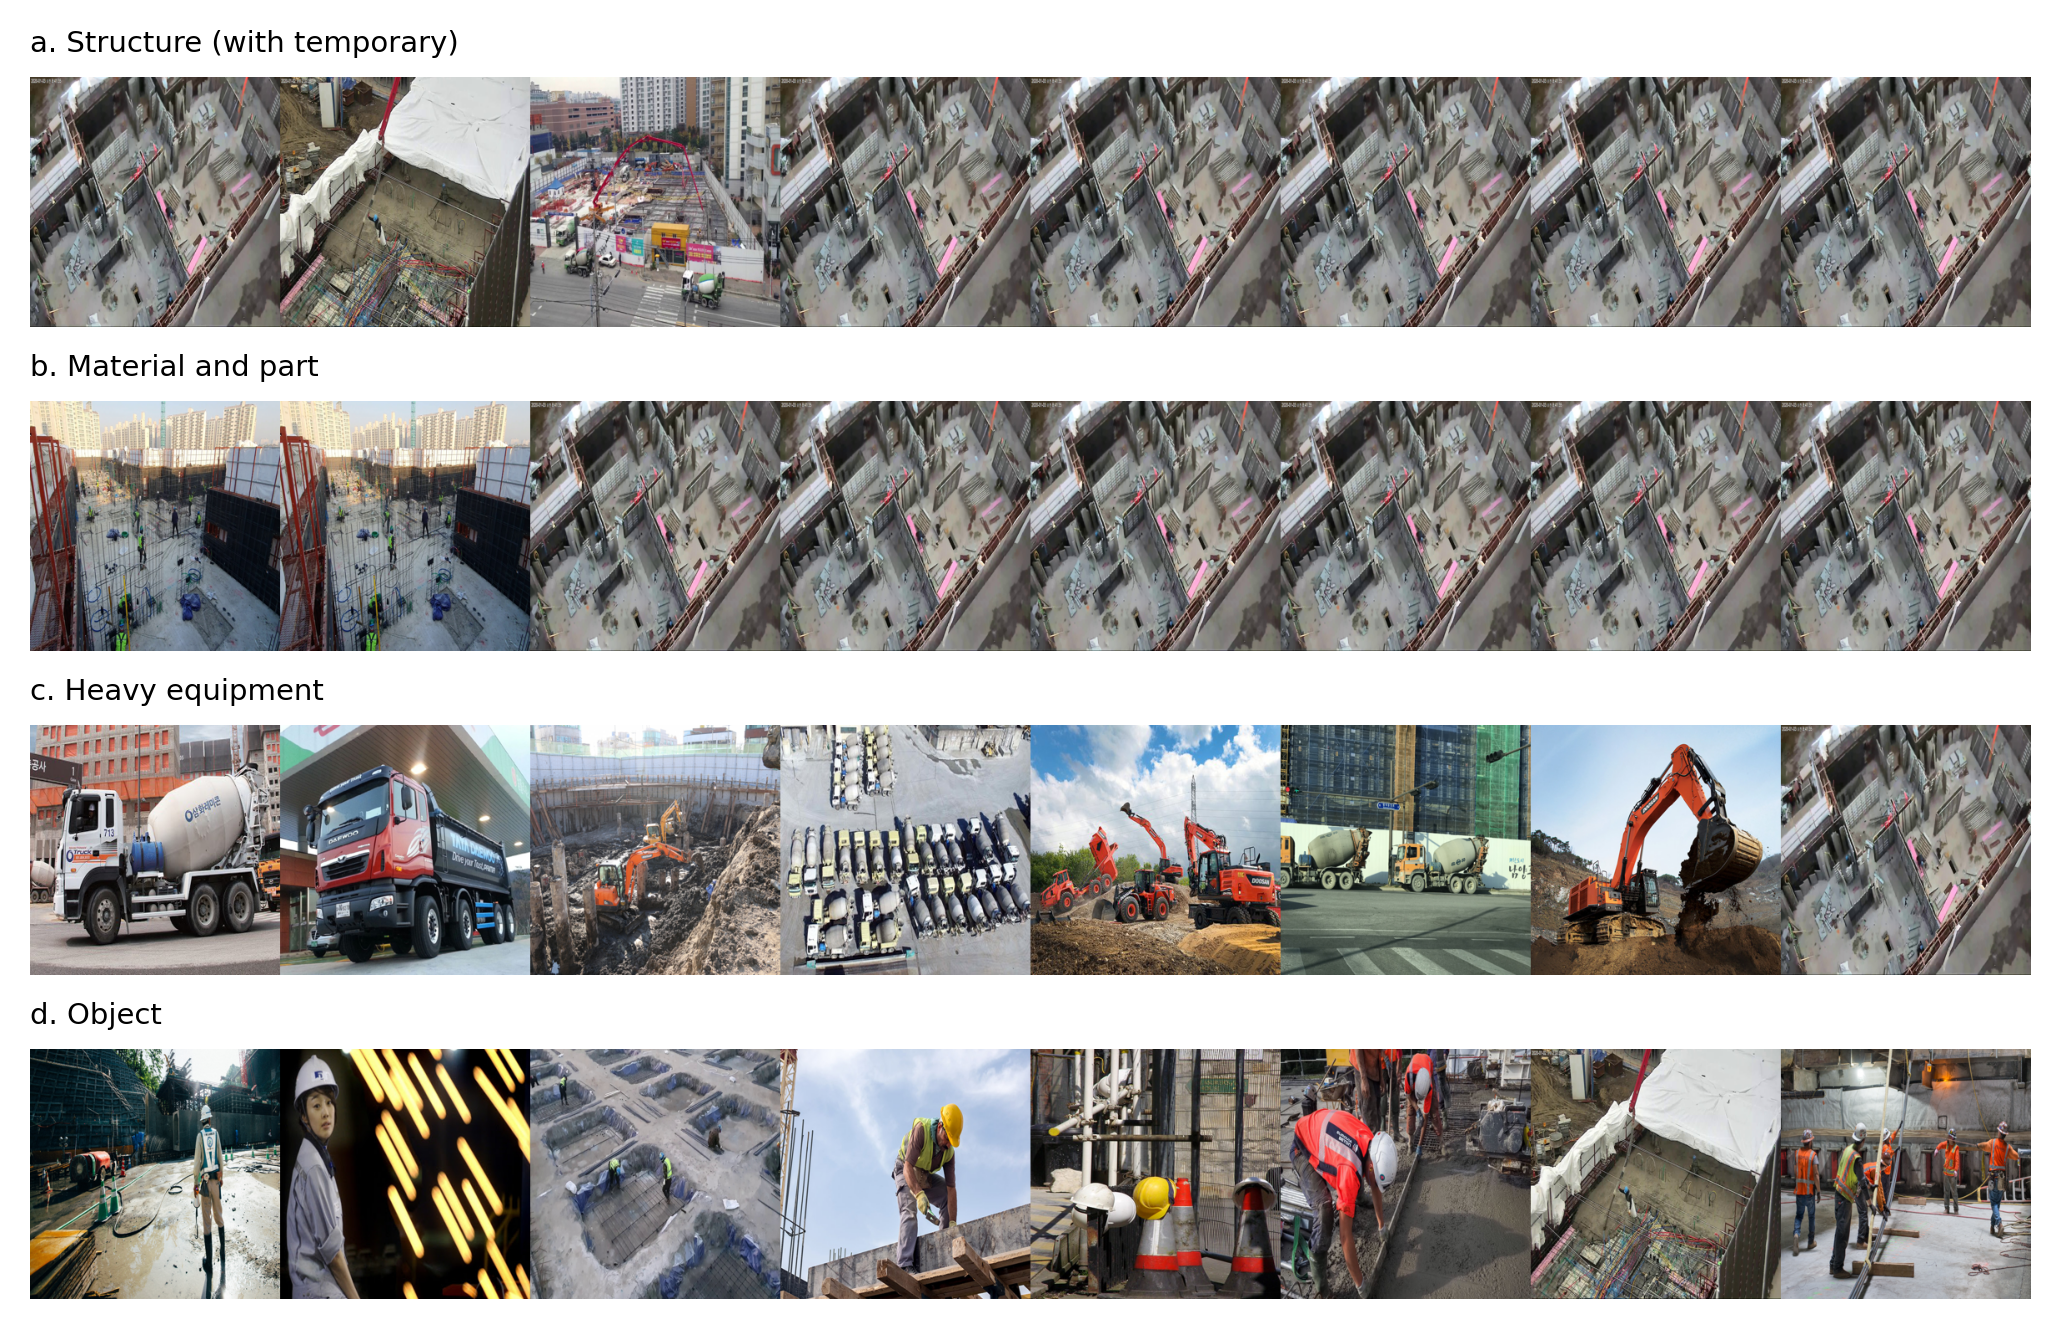

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(7,4.5), dpi=300)

s = ['a', 'b', 'c', 'd']
for i, (k, v) in enumerate(images_by_categories.items()):
    axes.flat[i].imshow(concat_horizon(images=v))
    axes.flat[i].axis('off')
    axes.flat[i].set_title(f'{s[i]}. {k}', fontsize=7, loc='left')  # weight='bold'

fig.tight_layout()
plt.show()
# fig.savefig('./outputs/fig-0102.png', bbox_inches='tight')

### Figure 2. Difference between bounding box and polygon

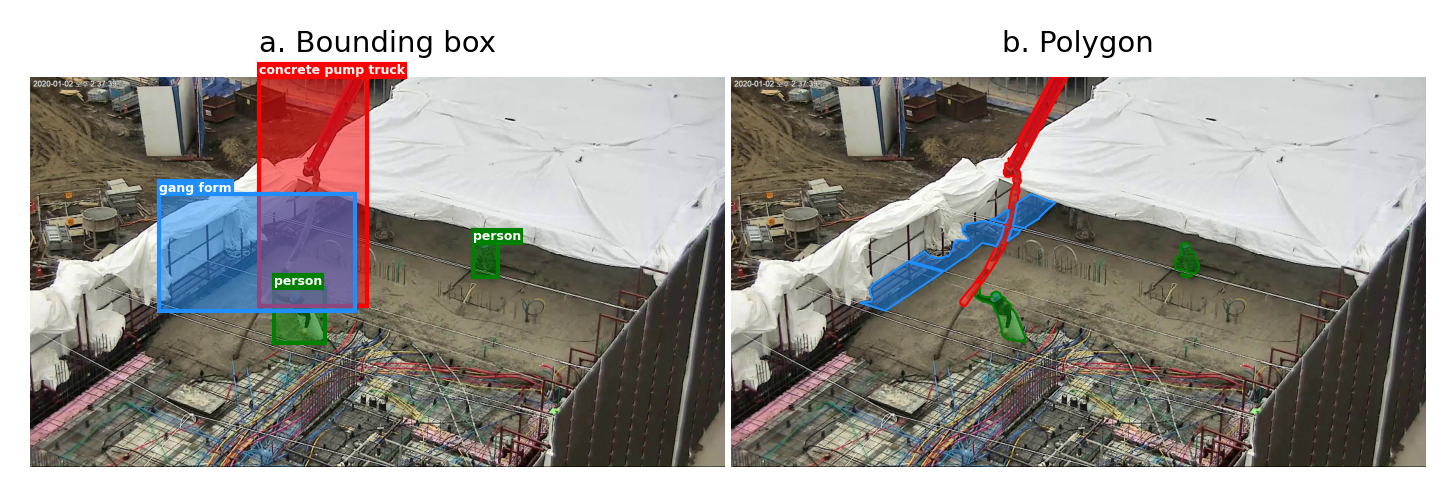

In [8]:
shapes = get_labelme_annotations('./inputs/labelme/10000351.json', xywh=True)

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

image = Image.open('./inputs/labelme/10000351.jpg')
ax1.imshow(image)
for shape in shapes['boxes']:
    if shape['label'] in ['person', 'gang form', 'concrete pump truck']:
        box = shape['points']
        color = colors_map.get(shape['label'], 1)
        rectangle = Rectangle((box[0], box[1]), box[2], box[3], fc=color[0], ec=color[1])
        ax1.add_patch(rectangle)
        
        ax1.annotate(
            shape['label'], (box[0], box[1]), color='w', weight='bold', 
            fontsize=3, ha='left', va='bottom', 
            bbox=dict(facecolor=color[1], edgecolor=color[1], pad=0.0))
        
ax2.imshow(image)
for shape in shapes['polygons']:
    if shape['label'] in ['person', 'gang form', 'concrete pump truck']:
        color = colors_map.get(shape['label'], 1)
        points = np.asarray(shape['points'])
        polygon = Polygon(points, True, fc=color[0], ec=color[1], lw=0.5)
        ax2.add_patch(polygon)

ax1.axis('off')
ax2.axis('off')
ax1.set_title('a. Bounding box', fontsize=7)
ax2.set_title('b. Polygon', fontsize=7)
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()
# fig.savefig('./outputs/fig-0103.png', bbox_inches='tight')

### Figure 3. 

In [9]:
colors_map = {
    'safety vest': rgb_to_rgba((30, 144, 255), 0.2),
    'person': rgb_to_rgba((0, 128, 0), 0.5),
    'empty': rgb_to_rgba((138, 43, 226), 0.5),
    'warning': rgb_to_rgba((255, 0, 0), 0.5),
    'hardhat': rgb_to_rgba((255, 255, 0), 0.5),
    'empty2': rgb_to_rgba((255, 95, 119), 0.5),
    'worker': rgb_to_rgba((0, 128, 0), 0.5),
    'concrete mixer truck': rgb_to_rgba((255, 123, 0), 0.5)
}

In [14]:
image = Image.open('./inputs/labelme/00000178.jpg')

boxes1 = get_labelme_annotations('./inputs/labelme/00000178.json')['boxes']
boxes2 = get_labelme_annotations('./inputs/labelme/00000178.json', xywh=False)['boxes']

polygons = get_labelme_annotations('./inputs/labelme/00000178.json')['polygons']

In [15]:
def jaccard(bboxes1, bboxes2):
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    
    return iou

In [18]:
def draw_plot1(ax, boxes, shapes):
    for shape in boxes:
        box = shape['points']
        color = colors_map.get(shape['label'], 1)
        rectangle = Rectangle((box[0], box[1]), box[2], box[3], fc='none', ec=color[1])
        ax.add_patch(rectangle)
        ax.annotate(
            shape['label'], (box[0], box[1]), color='w', weight='bold', 
            fontsize=8, ha='left', va='bottom', 
            bbox=dict(facecolor=color[1], edgecolor=color[1], pad=0.0))

    for shape in shapes:
        color = colors_map.get(shape['label'], 1)
        points = np.asarray(shape['points'])
        polygon = Polygon(points, True, fc=color[0], ec=color[1], lw=0.5)
        ax.add_patch(polygon)

    ax.axis('off')

    
def draw_plot2(ax, boxes, shapes):
    workers = {0: [], 1: [], 2: [], 3: []}
    empty = []
    num_person = 0
    for box in boxes:
        if box['label'] == 'person':
            person = np.array(box['points'])
            for box2 in boxes:
                if box2['label'] == 'hardhat':
                    hardhat = np.array(box2['points'])
                    iou = jaccard(person[np.newaxis,:], hardhat[np.newaxis,:])[0][0]
                    if iou >= 0.03:
                        copy_person = copy.copy(person)
                        copy_person[2:] = person[2:] - person[:2]
                        empty.append({
                            'label': 'worker',
                            'points': copy_person.tolist()})
            
                        workers[num_person].append(('bbox', iou))
                        num_person += 1
                        
                    elif iou < 0.0066 and iou > 0.0:
                        copy_person = copy.copy(person)
                        copy_person[2:] = copy_person[2:] - copy_person[:2]
                        empty.append({
                            'label': 'warning',
                            'points': copy_person.tolist()})
                        workers[num_person].append(('bbox', iou))
                        num_person += 1
                        
        elif box['label'] != 'person' and box['label'] != 'hardhat':
            copy_box = np.array(copy.copy(box['points']))
            copy_box[2:] = copy_box[2:] - copy_box[:2]
            empty.append({
                'label': box['label'],
                'points': copy_box.tolist()})
            
    for shape in empty:
        box = shape['points']
        color = colors_map.get(shape['label'], 1)
        rectangle = Rectangle((box[0], box[1]), box[2], box[3], fc='none', ec=color[1])
        ax.add_patch(rectangle)
        ax.annotate(
            shape['label'], (box[0], box[1]), color='w', weight='bold', 
            fontsize=3, ha='left', va='bottom', 
            bbox=dict(facecolor=color[1], edgecolor=color[1], pad=0.0))
    
    i = 0
    for shape in shapes:
        if shape['label'] in ['person', 'concrete mixer truck']:
            if i == 1:
                color = rgb_to_rgba((255, 0, 0), 0.5)
                points = np.asarray(shape['points'])
                polygon = Polygon(points, True, fc=color[0], ec=color[1], lw=0.5)
                ax.add_patch(polygon)
            else:
                color = colors_map.get(shape['label'], 1)
                points = np.asarray(shape['points'])
                polygon = Polygon(points, True, fc=color[0], ec=color[1], lw=0.5)
                ax.add_patch(polygon)
            i += 1

    ax.axis('off')

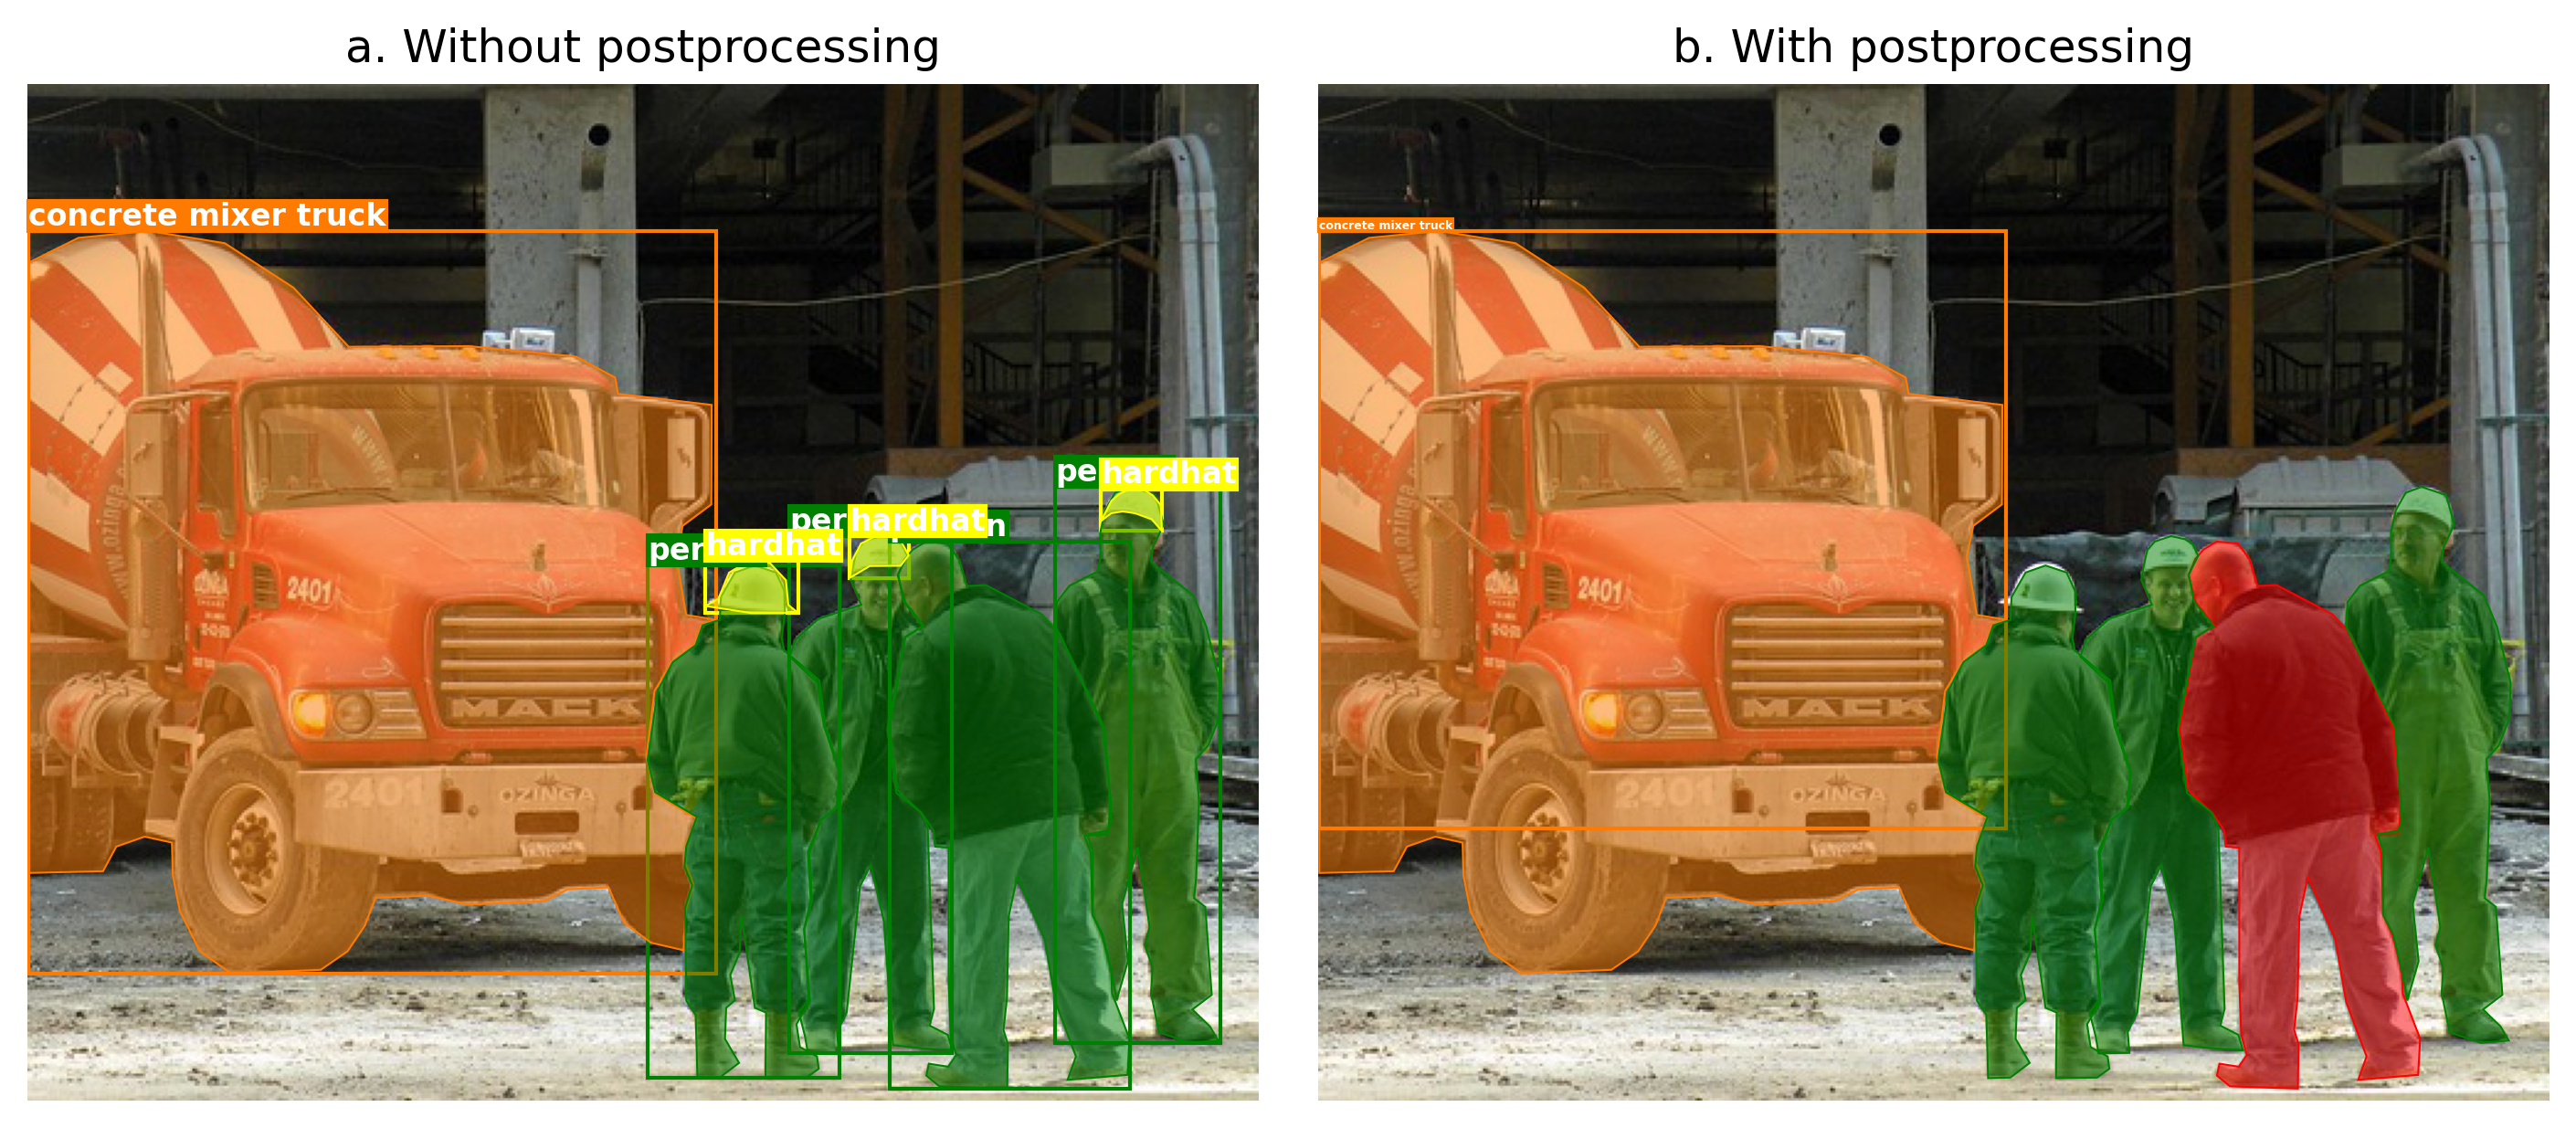

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5,5), dpi=300)

ax1.imshow(image)
ax2.imshow(image)
draw_plot1(ax1, boxes1, polygons)
draw_plot2(ax2, boxes1, polygons)
ax1.set_title('a. Without postprocessing', fontsize=12)
ax2.set_title('b. With postprocessing', fontsize=12)
fig.tight_layout()
plt.show()
# fig.savefig('fig-02.png', bbox_inches = 'tight')